## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 1.Import</div>

In [1]:
# !pip -q install scikit-survival

In [2]:
import pandas as pd
import zipfile
import io
import os
import numpy as np
import gc
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
import seaborn as sns
import pickle

from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# pd.set_option('display.max_rows',None)
# pd.set_option('display.max_columns',None)
pd.options.display.float_format ='{:,.2f}'.format
plt.rcParams["figure.figsize"] = (12, 12)

In [3]:
df = pd.read_csv('df_2022_2024.csv')

/tmp/ipykernel_76118/2910521507.py:1: DtypeWarning: Columns (95,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_2022_2024.csv')


Добавление колонки с периодом

In [ ]:
def append_period_col(df):
    """Функция добавляющая колонку с периодои между датой начала исследования и датой
    последней записи по каждому диску"""
    df["date"] = pd.to_datetime(df["date"])
    first_date = pd.to_datetime("01-01-2022")
    df["days_between"] = df.groupby("serial_number")["date"].transform(
        lambda x: (x.max() - first_date).days
    )
    return df

In [ ]:
df = append_period_col(df)

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 2. EDA</div>

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

Соединим с файлом, где есть типы дисков.

In [5]:
models = pd.read_csv('models.csv')

In [6]:
df = df.merge(models, on='model')

In [7]:
df['type'].isna().sum()

np.int64(0)

In [8]:
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_2_raw,smart_3_raw,smart_4_raw,smart_5_raw,...,smart_90_raw,datacenter,cluster_id,pod_slot_num,smart_27_raw,smart_82_raw,smart_211_raw,smart_212_raw,days_between,type
0,2022-01-28,10K0A0BWF97G,TOSHIBA MG07ACA14TA,14000519643136,1,0.00,0.00,"2,597.00",186.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,HDD
1,2022-01-28,ZHZ62N5X,ST12000NM0008,12000138625024,1,"230,825,528.00",NaN,0.00,5.00,208.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,HDD
2,2022-01-28,Z302SZP4,ST4000DM000,4000787030016,1,"26,511,648.00",NaN,0.00,17.00,8.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,HDD
3,2022-01-28,ZLW18DZ3,ST14000NM001G,14000519643136,1,"186,696,748.00",NaN,0.00,3.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,HDD
4,2022-01-28,Z305D2FN,ST4000DM000,4000787030016,1,"169,787,688.00",NaN,0.00,14.00,8.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,HDD


In [9]:
df.shape

(18819, 106)

In [10]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")

Количество дубликатов: 0


Эти столбцы описаны владельцем датасета и представляют ценность в рамках его бизнеса.\
Их можно удалить.
- Vault_id: All data drives are members of a Backblaze Vault. Each vault consists of either 900 or 1,200 hard drives divided evenly across 20 storage servers.  The vault is a numeric value starting at 1,000.
- Pod_id: There are 20 storage servers in each Backblaze Vault. The Pod_id is a numeric field with values from 0 to 19 assigned to one of the 20 storage servers.
- Is_legacy_format: Currently 0, but will be useful over the coming quarters as more fields are added.
- datacenter: The Backblaze data center where the drive is installed, currently one of these values: ams5, iad1, phx1, sac0, and sac2.
- cluster_id: The name of a given collection of storage servers logically grouped together to optimize system performance. Note: At this time the cluster_id is not always correct, we are working on fixing that.
- pod_slot_num: The physical location of a drive within a storage server. The specific slot differs based on the storage server type and capacity: Backblaze (45 drives), Backblaze (60 drives), Dell (26 drives), or Supermicro (60 drives). We’ll dig into these differences in another post.

In [11]:
df.drop(
    columns=[
        "vault_id",
        "pod_id",
        "is_legacy_format",
        "datacenter",
        "cluster_id",
        "pod_slot_num",
    ],
    errors="ignore",
    inplace=True
)

Также можно удалить строки с пропусками по всем датчикам.

In [12]:
df = df.dropna(subset=(df.filter(regex='raw').columns).to_list(), how='all')

In [13]:
df.groupby(['days_between'])['failure'].sum().to_frame().T

days_between,0,1,2,3,4,5,6,7,8,9,...,902,903,904,905,906,907,908,909,910,911
failure,3,6,8,5,6,12,4,5,4,5,...,15,6,17,17,15,11,9,7,6,7


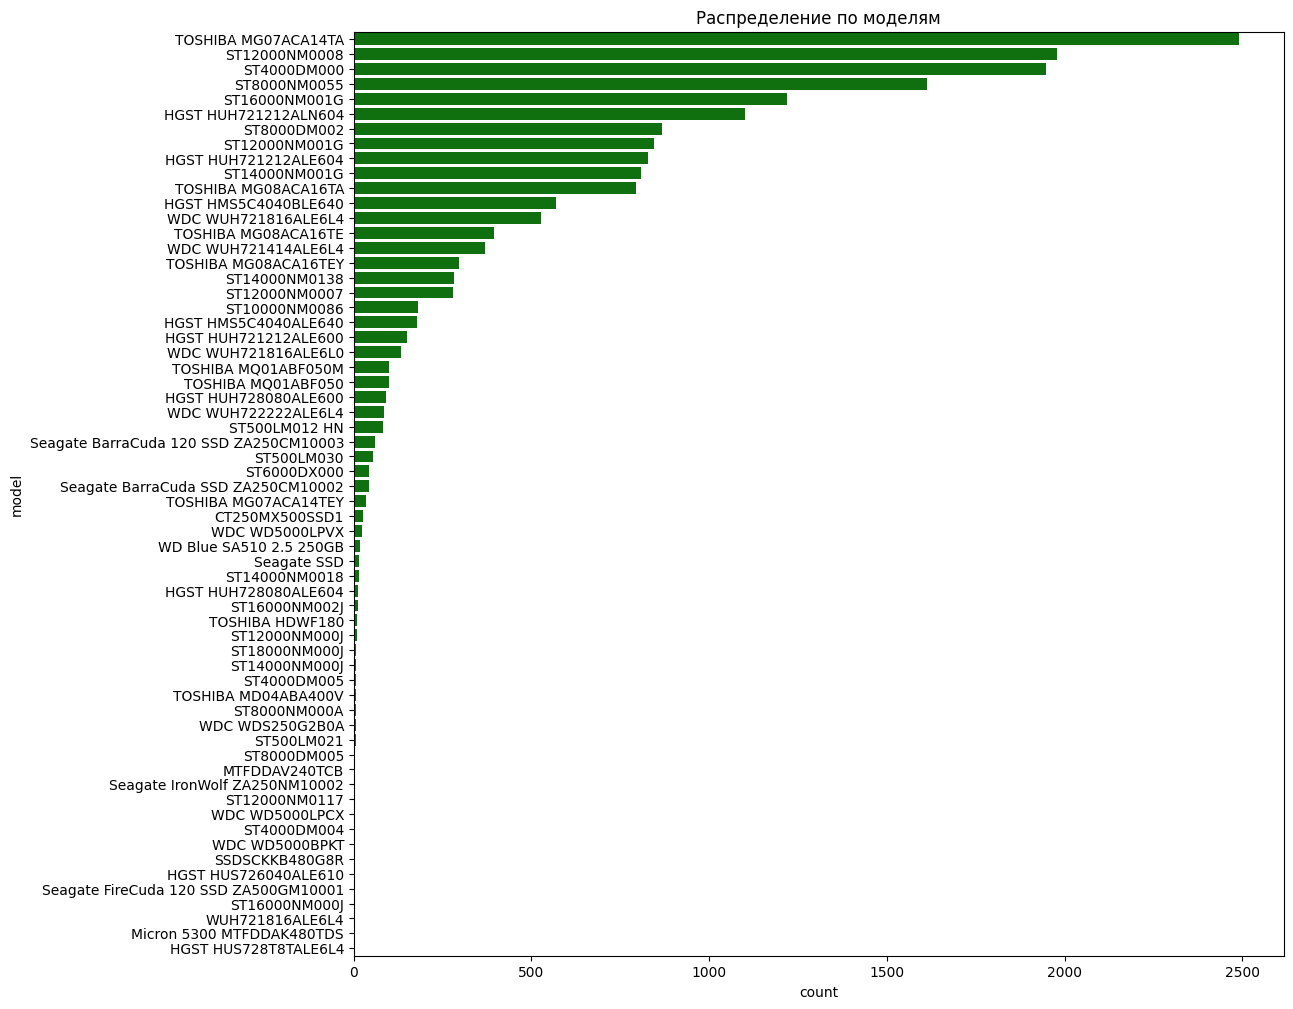

In [14]:
plt.title('Распределение по моделям')
sns.barplot(df.model.value_counts(), color='g', orient='h', )
plt.show()

Видно, что модели в датасете представлены не равномерно, поэтому использовать данный признак для предсказания не стоит. 

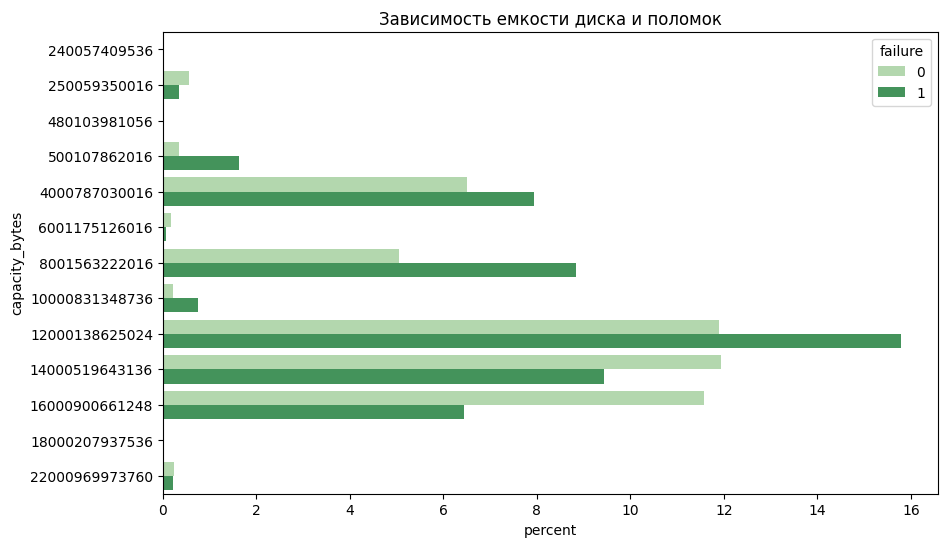

In [15]:
plt.figure(figsize=(10,6))
plt.title('Зависимость емкости диска и поломок')
sns.countplot(df, y='capacity_bytes', hue='failure',palette='Greens', stat='percent')
plt.show()

Зависимость от емкости диска на первый взляд не видна.

Посмотрим картину по пропускам.

<Axes: >

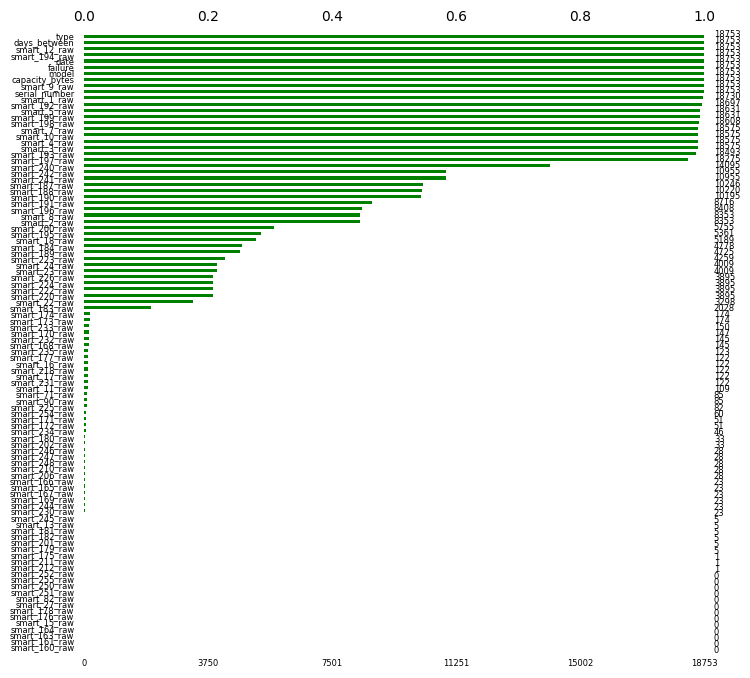

In [16]:
msno.bar(df, color="green", figsize=(8, 8), fontsize=6, sort='ascending')

Мы видим, что около половины признаков имеют количество пропусков, стремящееся к 100%.\
Есть датчики, которые снимают показания только с дисков SSD. Есть смысл разделить данные по типам дисков.

<div class="alert alert-success">
<h3>Вывод:</h3>
Согласно информации по датчикам SMART есть датчики, которые используются только для SSD дисков. Некорректно будет заполнять пропущенные значения по HDD дискам в случае физического отсутствия на них датчика.
План:
- Разделим данные по типу диска
- Выделим наиболее важные признаки для каждого типа
- Обозначим общие важные признаки для обоих типов

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 3. Features importances</div>

### SSD

In [17]:
mask  = df["type"] == 'SSD'

In [18]:
df_ssd = df[mask]

In [19]:
df_ssd.failure.value_counts()

failure
0    107
1     71
Name: count, dtype: int64

Удалим столбцы с кол-вом пропусков более 30%.

In [20]:
missing_cols = (df_ssd.isnull().mean() * 100).to_frame(name='null').reset_index()
missing_cols.shape

(100, 2)

In [21]:
cols_to_del = missing_cols.loc[missing_cols['null'] > 30]
cols_to_del.shape

(81, 2)

In [22]:
df_ssd = df_ssd.drop(columns=cols_to_del.iloc[:, 0])

In [23]:
df_ssd.drop(columns=['serial_number', 'date', 'type'], inplace=True)

Проверим колонки, где одно уникальное значение.

In [24]:
for col in df_ssd.columns:
  if df_ssd[col].nunique() == 1:
    print(f'{col} {df_ssd[col].isna().sum()}')

##### Correlation

Посмотрим на корреляцию между признаками.

In [25]:
corr_matrix = df_ssd.select_dtypes(include='number').corr()

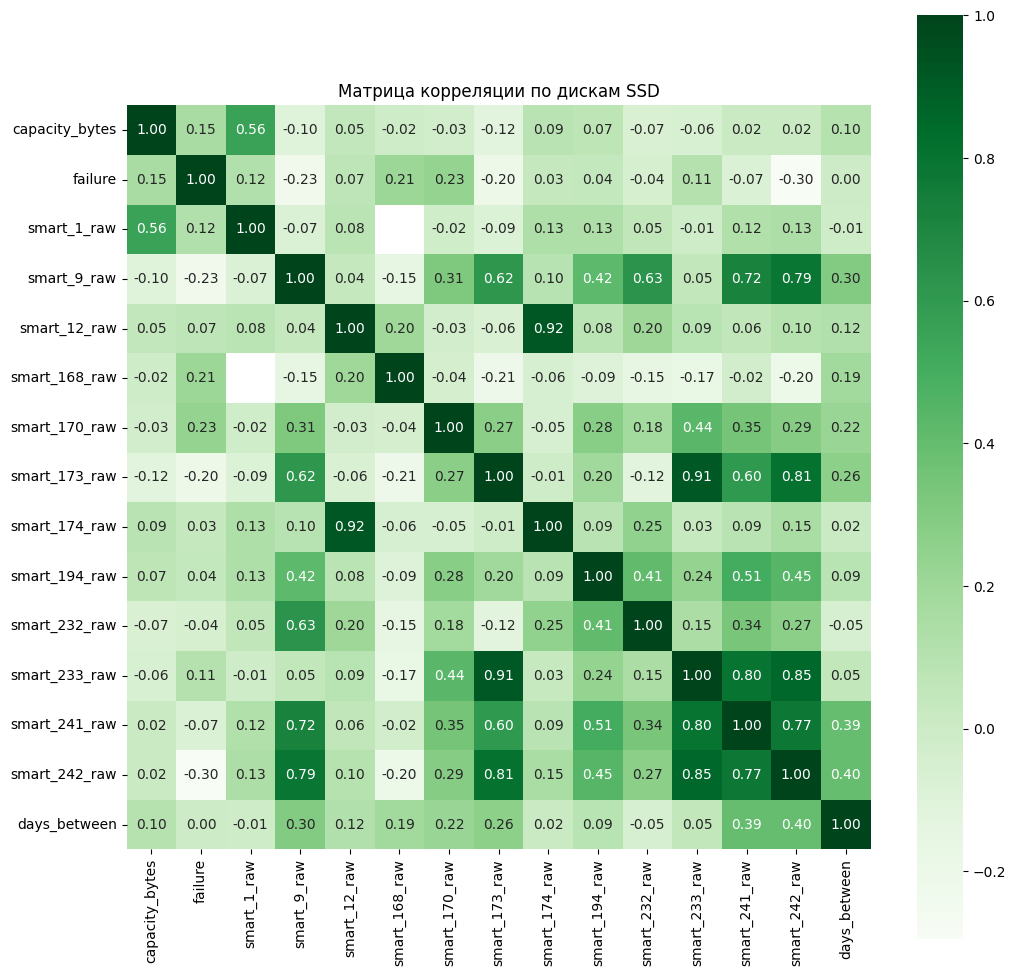

In [26]:
plt.title('Матрица корреляции по дискам SSD')
sns.heatmap(
    corr_matrix,
    cmap="Greens",
    fmt=".2f",
    annot=True,
    square=True,
)
plt.yticks(rotation=0)
plt.show()

In [27]:
df_ssd.isna().sum().sort_values(ascending=False)

smart_168_raw     33
smart_232_raw     33
smart_241_raw     32
smart_242_raw     32
smart_170_raw     31
smart_233_raw     28
smart_1_raw       23
smart_173_raw      4
smart_174_raw      4
smart_9_raw        0
capacity_bytes     0
failure            0
model              0
smart_12_raw       0
smart_194_raw      0
days_between       0
dtype: int64

In [28]:
df_ssd.select_dtypes(include="number").apply(lambda col: (col == 0).sum())

capacity_bytes      0
failure           107
smart_1_raw       153
smart_9_raw         3
smart_12_raw        0
smart_168_raw     122
smart_170_raw      20
smart_173_raw       0
smart_174_raw      24
smart_194_raw       0
smart_232_raw      65
smart_233_raw       0
smart_241_raw       0
smart_242_raw       0
days_between        0
dtype: int64

In [29]:
corr_matrix_abs = df_ssd.select_dtypes(include='number').corr().abs()

upper_triangle = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_pairs = [(column, row) for column in upper_triangle.columns for row in upper_triangle.index if upper_triangle.loc[row, column] > 0.80]

print("Пары признаков с корреляцией более 80%:")
for pair in high_corr_pairs:
    print(pair)

Пары признаков с корреляцией более 80%:
('smart_174_raw', 'smart_12_raw')
('smart_233_raw', 'smart_173_raw')
('smart_241_raw', 'smart_233_raw')
('smart_242_raw', 'smart_173_raw')
('smart_242_raw', 'smart_233_raw')


Описание датчиков:

- 174 - Число неожиданных отключений питания, когда питание было потеряно до получения команды на отключение диска.
- 12  - Количество полных циклов включения-выключения диска. 
- 173 - Максимальное количество операций стирания, выполняемых для одного блока флэш-памяти. 
- 233 - нет инфо
- 241 - У SSD Kingston — объём записанного за всё время жизни накопителя.
- 242 - нет инфо

Удалим столбцы с высокой корреляцией, возьмем те, у которых пропусков больше.

In [30]:
df_ssd = df_ssd.drop(
    columns=[
        "smart_174_raw",
        "smart_233_raw",
        "smart_242_raw",
    ]
)

##### Missing

<Axes: >

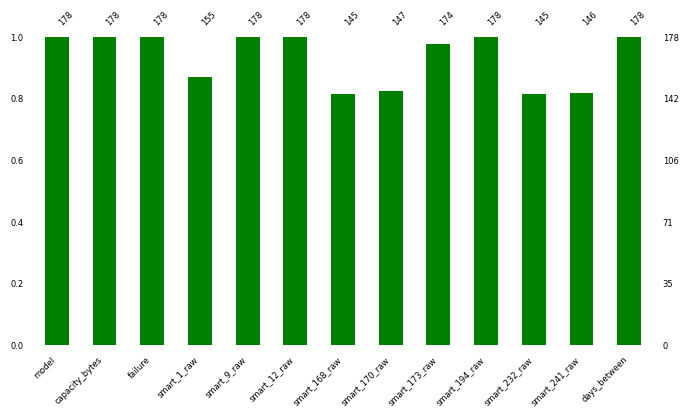

In [31]:
msno.bar(df_ssd, color="green", figsize=(8, 4), fontsize=6, labels=None)

Заполнять пропуски будет медианным значением, так как нет информации по ряду датчиков.

##### Description

In [32]:
df_ssd.describe().T

,count,mean,std,min,25%,50%,75%,max
capacity_bytes,178.00,"253,824,125,365.21","30,646,756,235.85","240,057,409,536.00","250,059,350,016.00","250,059,350,016.00","250,059,350,016.00","500,107,862,016.00"
failure,178.00,0.40,0.49,0.00,0.00,0.00,1.00,1.00
smart_1_raw,155.00,"18,052,039.21","224,746,075.50",0.00,0.00,0.00,0.00,"2,798,066,075.00"
smart_9_raw,178.00,"16,714.69","11,039.60",0.00,"8,354.75","16,293.50","25,196.75","44,501.00"
smart_12_raw,178.00,14.61,21.74,2.00,6.25,10.00,14.75,231.00
smart_168_raw,145.00,46.89,245.74,0.00,0.00,0.00,0.00,"2,761.00"
smart_170_raw,147.00,"43,329,500,098.76","217,234,425,359.59",0.00,85.00,101.00,131.00,"1,554,778,161,272.00"
smart_173_raw,174.00,"2,184,865,448,376.65","2,386,889,442,397.53",1.00,"1,439.00","1,503,264,309,699.00","3,365,160,846,196.00","8,723,214,305,363.00"
smart_194_raw,178.00,36.30,5.91,24.00,32.00,36.00,40.00,52.00
smart_232_raw,145.00,"177,989,368,865.87","222,626,428,010.03",0.00,0.00,95.00,"459,561,500,672.00","476,741,369,856.00"


In [33]:
df_ssd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 204 to 18436
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model           178 non-null    object 
 1   capacity_bytes  178 non-null    int64  
 2   failure         178 non-null    int64  
 3   smart_1_raw     155 non-null    float64
 4   smart_9_raw     178 non-null    float64
 5   smart_12_raw    178 non-null    float64
 6   smart_168_raw   145 non-null    float64
 7   smart_170_raw   147 non-null    float64
 8   smart_173_raw   174 non-null    float64
 9   smart_194_raw   178 non-null    float64
 10  smart_232_raw   145 non-null    float64
 11  smart_241_raw   146 non-null    float64
 12  days_between    178 non-null    int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 19.5+ KB


In [34]:
# df.groupby(["smart_168_raw", "failure"])["failure"].agg("count").to_frame(name="count")

##### Preprocessing

In [35]:
df_ssd.columns

Index(['model', 'capacity_bytes', 'failure', 'smart_1_raw', 'smart_9_raw',
       'smart_12_raw', 'smart_168_raw', 'smart_170_raw', 'smart_173_raw',
       'smart_194_raw', 'smart_232_raw', 'smart_241_raw', 'days_between'],
      dtype='object')

In [36]:
y = df_ssd[['failure', 'days_between']].copy()
y['failure'] = y['failure'].astype('bool')
X = df_ssd.drop(columns= ['failure', 'days_between', 'model'])

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]),  X.select_dtypes(include="number").columns),

        # ('cat', Pipeline(steps=[
        #     ('encoder', OneHotEncoder(handle_unknown='ignore'))
        # ]), X.select_dtypes(exclude="number").columns)
      ]
    )

In [38]:
preprocessor.fit(X)
X= preprocessor.transform(X)
cols = [x.split("__")[-1] for x in preprocessor.get_feature_names_out()]

##### PLS

In [39]:
pls = PLSRegression()
pls.fit(X, y)

PLSRegression()

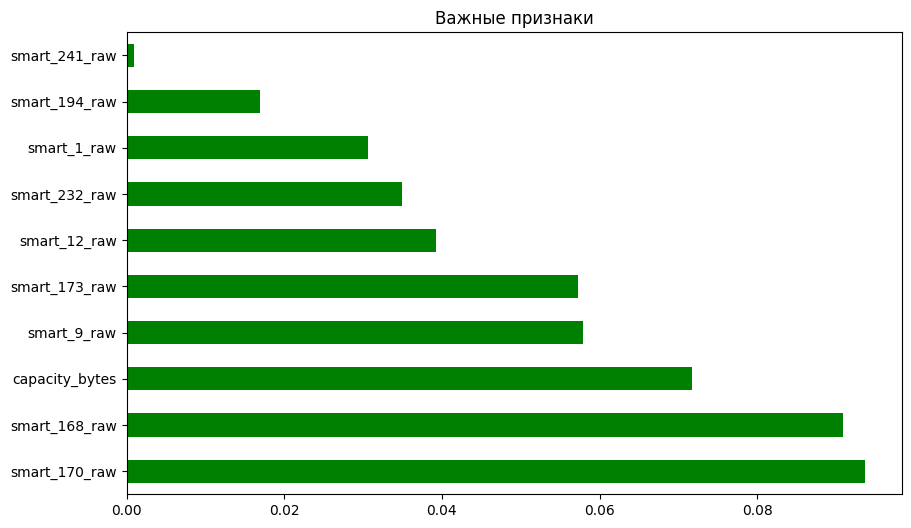

In [40]:
plt.figure(figsize=(10,6))
feature_importances = pd.Series(
    abs(pls.coef_[0]),
    index=cols,
).sort_values(ascending=False)

plt.title("Важные признаки")
feature_importances.plot(kind="barh", color='green')
plt.show()

##### Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1234)

In [42]:
y_train = Surv.from_dataframe('failure', 'days_between', y_train)
y_test = Surv.from_dataframe('failure', 'days_between', y_test)

##### Model

In [43]:
gc.collect()
rsf = RandomSurvivalForest(max_depth=10, n_estimators=100, random_state=1234, n_jobs=-1)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_depth=10, n_jobs=-1, random_state=1234)

In [44]:
rsf.score(X_train, y_train)

np.float64(0.8937621832358674)

In [45]:
rsf.score(X_test, y_test)

np.float64(0.7104072398190046)

In [46]:
gc.collect()

84

Посмотрим на важные признаки с точки зрения модели.

In [47]:
features = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=1234)

In [48]:
pd.DataFrame(
    {
        k: abs(features[k])
        for k in (
            "importances_mean",
            # "importances_std",
        )
    },
    index=cols,
).sort_values(by="importances_mean", ascending=False)

,importances_mean
smart_9_raw,0.09
smart_241_raw,0.07
smart_12_raw,0.04
smart_194_raw,0.01
smart_173_raw,0.00
smart_168_raw,0.00
smart_170_raw,0.00
smart_232_raw,0.00
smart_1_raw,0.00
capacity_bytes,0.00


<div class="alert alert-success">
<h3>Вывод:</h3>
Для SSD дисков в модели будем использовать следующие:

- smart_9_raw
- smart_241_raw
- smart_12_raw
- smart_194_raw
- smart_173_raw
- smart_168_raw
- smart_170_raw
- smart_232_raw
- smart_1_raw
- capacity_bytes

### HDD

Создадим отдельный датафрейм

In [49]:
df_hdd = df[~mask]

In [50]:
df_hdd.failure.value_counts()

failure
1    9585
0    8990
Name: count, dtype: int64

In [51]:
missing_cols = (df_hdd.isnull().mean() * 100).to_frame(name='null').reset_index()
missing_cols.shape

(100, 2)

Выделим колонки с более чем 30% пропусков и удалим их

In [52]:
cols_to_del = missing_cols.loc[missing_cols['null'] > 30]
print('Кол-во колонок с более 30% пропусков - ', cols_to_del.shape[0])

Кол-во колонок с более 30% пропусков -  78


In [53]:
df_hdd = df_hdd.drop(columns=cols_to_del.iloc[:, 0])

In [54]:
df_hdd.shape

(18575, 22)

In [55]:
df_hdd.drop(columns=['serial_number', 'date', 'type'], inplace=True)

In [56]:
df_hdd.describe(include='object')

,model
count,18575
unique,51
top,TOSHIBA MG07ACA14TA
freq,2492


##### Correlation

Посмотрим корреляцию признаков.

In [57]:
corr_matrix = df_hdd.select_dtypes(include='number').corr()

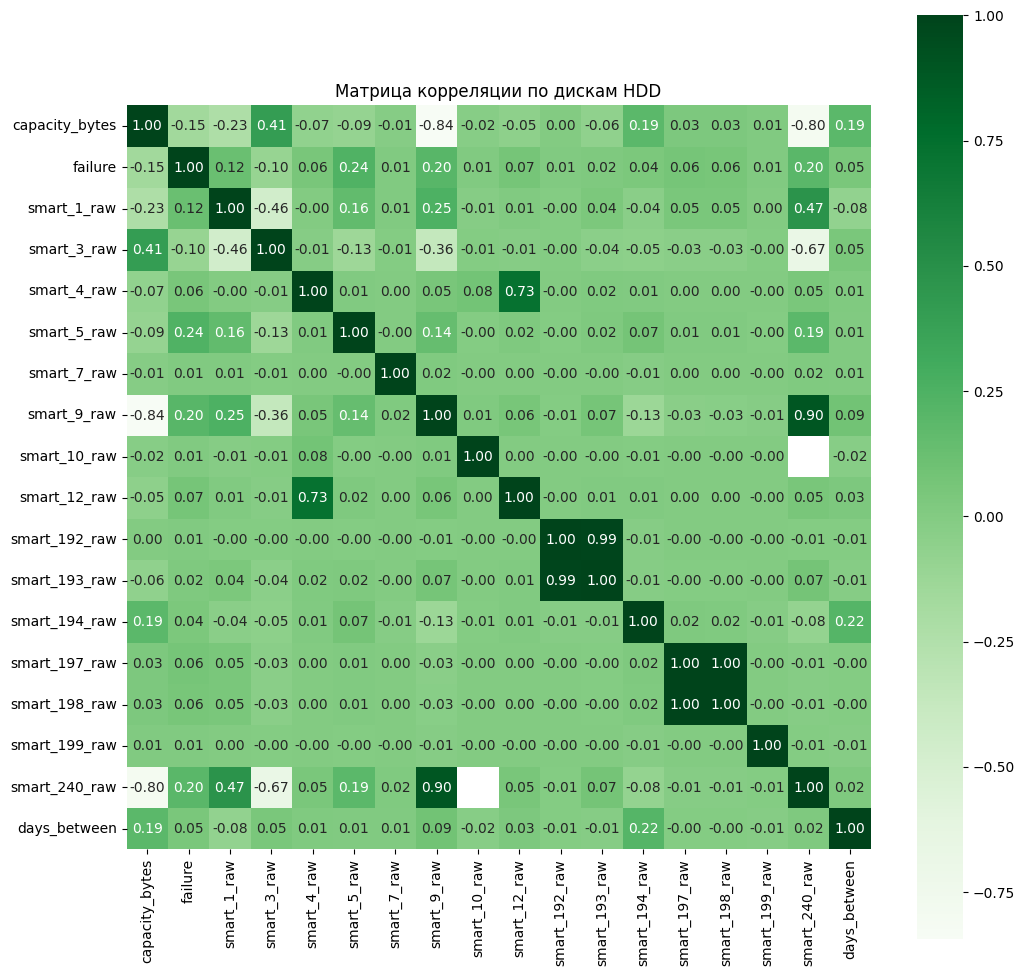

In [58]:
plt.title('Матрица корреляции по дискам HDD')
sns.heatmap(
    corr_matrix,
    cmap="Greens",
    fmt=".2f",
    annot=True,
    square=True,
)
plt.yticks(rotation=0)
plt.show()

In [59]:
corr_matrix_abs = corr_matrix.abs()

upper_triangle = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_pairs = [(column, row) for column in upper_triangle.columns for row in upper_triangle.index if upper_triangle.loc[row, column] > 0.80]

print("Пары признаков с корреляцией более 80%:")
for pair in high_corr_pairs:
    print(pair)

Пары признаков с корреляцией более 80%:
('smart_9_raw', 'capacity_bytes')
('smart_193_raw', 'smart_192_raw')
('smart_198_raw', 'smart_197_raw')
('smart_240_raw', 'smart_9_raw')


Описание датчиков:
- 192 - Число циклов выключений или аварийных отказов (включений/выключений питания накопителя). 
- 193 - Количество циклов перемещения блока магнитных головок в парковочную зону/в рабочее положение.
- 197 - Число секторов, являющихся кандидатами на замену. Рост значения этого атрибута может свидетельствовать о физической деградации жёсткого диска. 
- 198 - Число некорректируемых (средствами диска) секторов.
- 9 - Число часов (минут, секунд — в зависимости от производителя), проведённых во включенном состоянии. 
- 240 - Общее время нахождения блока головок в рабочем положении в часах. 

Корреляция логически объяснима.
Посмотрим, какие пропуски остались и удалим столбцы с сильной корреляцией, из пары тот - где больше пропусков.

##### Missing

<Axes: >

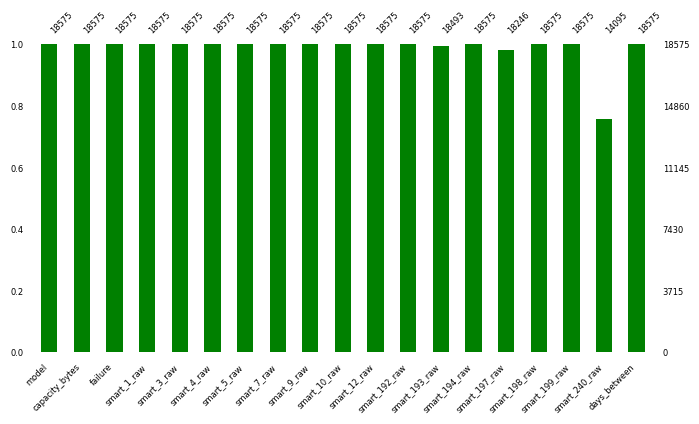

In [60]:
msno.bar(df_hdd, color="green", figsize=(8, 4), fontsize=6, labels=None)

In [61]:
df_hdd = df_hdd.drop(columns = ['smart_197_raw', 'smart_193_raw', 'smart_240_raw'])

In [62]:
df_hdd.isna().sum()

model             0
capacity_bytes    0
failure           0
smart_1_raw       0
smart_3_raw       0
smart_4_raw       0
smart_5_raw       0
smart_7_raw       0
smart_9_raw       0
smart_10_raw      0
smart_12_raw      0
smart_192_raw     0
smart_194_raw     0
smart_198_raw     0
smart_199_raw     0
days_between      0
dtype: int64

Пропусков больше нет. Но на их случай, в препроцессинге сделаем заполнение по медианному значению.


In [63]:
gc.collect()

27986

##### Description

In [64]:
df_hdd.describe().T

,count,mean,std,min,25%,50%,75%,max
capacity_bytes,"18,575.00","11,217,893,552,345.64","4,237,583,090,468.57","500,107,862,016.00","8,001,563,222,016.00","12,000,138,625,024.00","14,000,519,643,136.00","22,000,969,973,760.00"
failure,"18,575.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
smart_1_raw,"18,575.00","67,455,792.83","80,546,918.91",0.00,0.00,"22,009,544.00","133,707,368.00","554,179,095.00"
smart_3_raw,"18,575.00","1,742.14","3,153.20",0.00,0.00,0.00,542.00,"10,660.00"
smart_4_raw,"18,575.00",16.60,79.68,1.00,5.00,10.00,16.00,"4,230.00"
smart_5_raw,"18,575.00","1,961.64","7,797.19",0.00,0.00,0.00,8.00,"65,528.00"
smart_7_raw,"18,575.00","20,888,661,799.94","2,098,763,543,425.13",0.00,0.00,"99,493,996.00","712,639,266.50","281,471,003,655,490.00"
smart_9_raw,"18,575.00","31,448.89","19,398.65",0.00,"16,047.00","27,371.00","47,811.00","82,990.00"
smart_10_raw,"18,575.00",225.81,"17,522.31",0.00,0.00,0.00,0.00,"1,638,405.00"
smart_12_raw,"18,575.00",14.86,57.79,0.00,5.00,10.00,16.00,"3,873.00"


In [65]:
df_hdd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18575 entries, 0 to 18818
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model           18575 non-null  object 
 1   capacity_bytes  18575 non-null  int64  
 2   failure         18575 non-null  int64  
 3   smart_1_raw     18575 non-null  float64
 4   smart_3_raw     18575 non-null  float64
 5   smart_4_raw     18575 non-null  float64
 6   smart_5_raw     18575 non-null  float64
 7   smart_7_raw     18575 non-null  float64
 8   smart_9_raw     18575 non-null  float64
 9   smart_10_raw    18575 non-null  float64
 10  smart_12_raw    18575 non-null  float64
 11  smart_192_raw   18575 non-null  float64
 12  smart_194_raw   18575 non-null  float64
 13  smart_198_raw   18575 non-null  float64
 14  smart_199_raw   18575 non-null  float64
 15  days_between    18575 non-null  int64  
dtypes: float64(12), int64(3), object(1)
memory usage: 2.4+ MB


##### Preprocessing

In [66]:
y = df_hdd[['failure', 'days_between']].copy()
y['failure'] = y['failure'].astype('bool')
X = df_hdd.drop(columns= ['failure', 'days_between', 'model'])

In [67]:
num_feat =  X.select_dtypes(include="number")
len(num_feat.columns)

13

In [68]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]),  X.select_dtypes(include="number").columns),
      ]
    )

In [69]:
preprocessor.fit(X)
X= preprocessor.transform(X)
cols = [x.split("__")[-1] for x in preprocessor.get_feature_names_out()]

In [70]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(X)
normalized_df = pd.DataFrame(normalized_data, columns=cols)

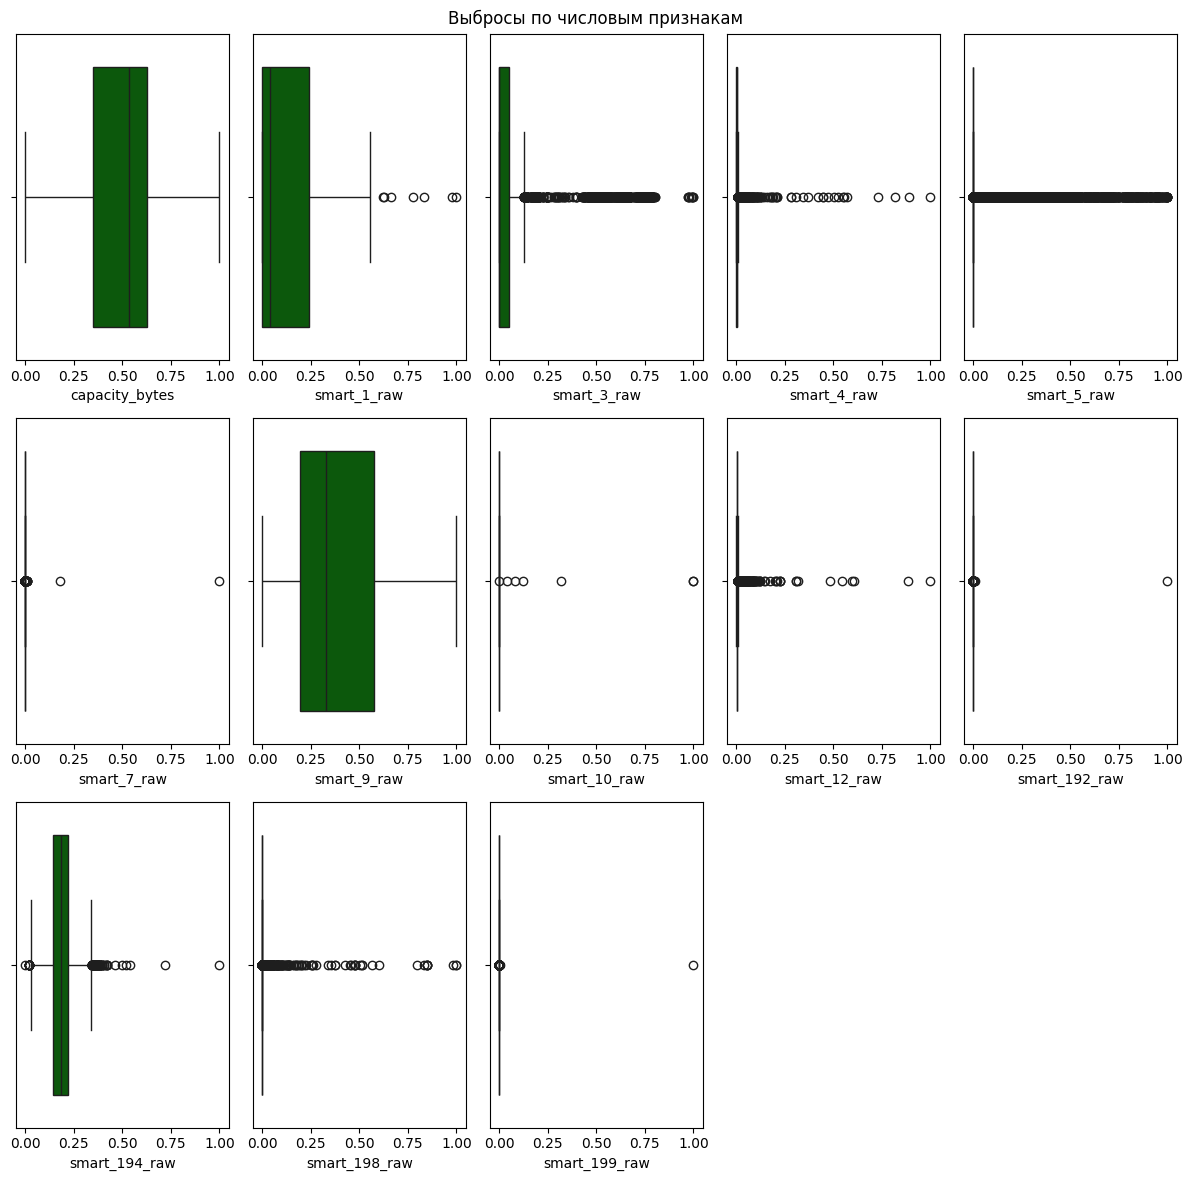

In [71]:
fig, ax = plt.subplots(3, 5)
fig.suptitle("Выбросы по числовым признакам")
i, j = 0, 0

for feat in num_feat.columns:
    sns.boxplot(
        normalized_df,
        x=feat,
        ax=ax[i][j],
        color="darkgreen",
    )
    j += 1
    if j == 5:
        i += 1
        j = 0
ax[2][3].remove()
ax[2][4].remove()
plt.tight_layout()
plt.show()


In [72]:
df.smart_199_raw.value_counts()

smart_199_raw
0.00        18323
1.00           36
3.00           19
2.00           16
5.00           14
            ...  
3,138.00        1
807.00          1
71.00           1
136.00          1
159.00          1
Name: count, Length: 105, dtype: int64

Выбросы в данных - это большие показания датчиков, сигнализирующие о проблемах.

##### PCA

Посмотрим, какие признаки оставить для модели с помощью методов PCA и PLSRegression.

In [73]:
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X)

In [74]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

In [75]:
fig = px.line(
    x=range(X_pca.shape[1]),
    y=cum_var_exp,
    markers=True,
    labels={"x": "Кол-во признаков", "y": "Объясненный коэффициент дисперсии"},
    title='Объясненная кумулятивная дисперсия по признакам'
)
fig.update_traces(line_color='green', line_width=5)
fig.show()

PCA говорит о том, что можно оставить все признаки.

In [76]:
gc.collect()

42

##### PLS

In [77]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression()
pls.fit(X, y)

PLSRegression()

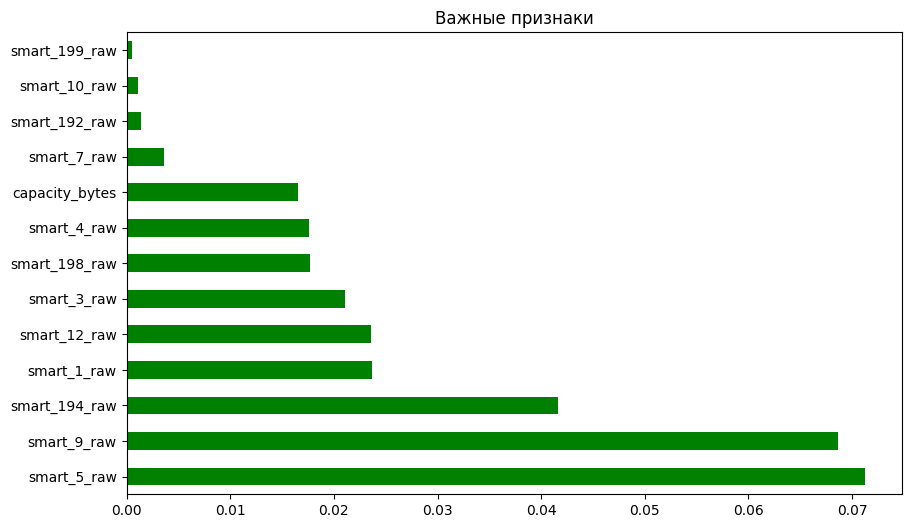

In [78]:
plt.figure(figsize=(10,6))
feature_importances = pd.Series(
    abs(pls.coef_[0]),
    index=cols,
).sort_values(ascending=False)

plt.title("Важные признаки")
feature_importances.plot(kind="barh", color='green')
plt.show()

##### VIF

Посмотрим корреляцию методом VIF и удалим сильно коррелирующие с остальными столбцы.

In [79]:
corr_matrix = np.array(pd.DataFrame(X).corr())
inv_corr_matrix = np.linalg.inv(corr_matrix)
mult_corr_feat = pd.DataFrame(np.diag(inv_corr_matrix), index=cols, columns=["VIF"]).sort_values(
    by="VIF", ascending=False
).reset_index()
mult_corr_feat#.style.background_gradient(cmap="Greens")

,index,VIF
0,capacity_bytes,3.80
1,smart_9_raw,3.59
2,smart_4_raw,2.18
3,smart_12_raw,2.16
4,smart_3_raw,1.49
5,smart_1_raw,1.31
6,smart_194_raw,1.07
7,smart_5_raw,1.05
8,smart_10_raw,1.01
9,smart_198_raw,1.01


Сильно коррелирующих признаков не обнаружено.

In [80]:
df.shape

(18753, 100)

In [81]:
gc.collect()

4741

##### Split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1234)

In [83]:
y_train = Surv.from_dataframe('failure', 'days_between', y_train)
y_test = Surv.from_dataframe('failure', 'days_between', y_test)

##### Model

In [84]:
gc.collect()
rsf = RandomSurvivalForest(
    max_depth = 3,
    n_estimators=5,
    random_state=1234,
    n_jobs=-1)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_depth=3, n_estimators=5, n_jobs=-1, random_state=1234)

In [85]:
rsf.score(X_train, y_train)

np.float64(0.7060439282925397)

In [86]:
rsf.score(X_test, y_test)

np.float64(0.6963443879026361)

In [87]:
gc.collect()

84

Посмотрим на важные признаки с точки зрения модели.

In [88]:
result = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=1234)

In [89]:
pd.DataFrame(
    {
        k: abs(result[k])
        for k in (
            "importances_mean",
            # "importances_std",
        )
    },
    index=cols,
).sort_values(by="importances_mean", ascending=False)

,importances_mean
smart_198_raw,0.07
smart_5_raw,0.05
capacity_bytes,0.02
smart_9_raw,0.01
smart_1_raw,0.01
smart_194_raw,0.01
smart_12_raw,0.00
smart_192_raw,0.00
smart_3_raw,0.00
smart_7_raw,0.00


<div class="alert alert-success">
<h3>Вывод:</h3>
Для HDD дисков в модели будем использовать следующие:

- capacity_bytes
- smart_1_raw
- smart_3_raw
- smart_4_raw
- smart_5_raw
- smart_7_raw
- smart_9_raw
- smart_12_raw
- smart_192_raw
- smart_194_raw
- smart_198_raw
- smart_10_raw
- smart_199_raw	

<h2>Общий вывод:</h2>
Разделение дисков по группам не дает хороший результат по дискам SSD, так как их очень мало представлено в данных.  

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 4. Model</div>

Общими для двух типов дисков являются следующие датчики:

- capacity_bytes
- smart_1_raw
- smart_9_raw
- smart_12_raw
- smart_194_raw

In [90]:
y = df[["failure", "days_between"]].copy()
y["failure"] = y["failure"].astype("bool")
X = df[
    [
        "smart_1_raw",
        "smart_9_raw",
        "smart_5_raw",
        "smart_12_raw",
        "smart_194_raw",
    ]
]

In [91]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]),  X.select_dtypes(include="number").columns),
      ]
    )

In [92]:
preprocessor.fit(X)
X= preprocessor.transform(X)
cols = [x.split("__")[-1] for x in preprocessor.get_feature_names_out()]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1234)

In [94]:
y_train = Surv.from_dataframe('failure', 'days_between', y_train)
y_test = Surv.from_dataframe('failure', 'days_between', y_test)

In [95]:
gc.collect()
rsf = RandomSurvivalForest(max_depth=3, n_estimators=5, random_state=1234, n_jobs=-1)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_depth=3, n_estimators=5, n_jobs=-1, random_state=1234)

In [96]:
rsf.score(X_train, y_train)

np.float64(0.6741408037020498)

In [97]:
gc.collect()
rsf.score(X_test, y_test)

np.float64(0.6777360237758647)

In [98]:
model_pkl_file = "model.pkl"
with open(model_pkl_file, 'wb') as file:
  pickle.dump(rsf, file)

In [99]:
# from google.colab import files
# files.download('model.pkl')

In [100]:
gc.collect()

28

In [101]:
pred = rsf.predict_survival_function(X_test)
times = np.array([60, 90, 364])
data = []
for i in range(len(pred)):
  for t in times:
    data.append({
            'index': i,
            'Time': t,
            'Survival Probability': pred[i](t)
        })

In [102]:
res = pd.DataFrame(data)
res_ = pd.DataFrame(y_test).reset_index()
result= pd.merge(res, res_, on='index')

In [103]:
result.head(10)

,index,Time,Survival Probability,failure,days_between
0,0,60,0.98,False,747.00
1,0,90,0.97,False,747.00
2,0,364,0.74,False,747.00
3,1,60,0.94,True,275.00
4,1,90,0.90,True,275.00
5,1,364,0.58,True,275.00
6,2,60,0.99,False,230.00
7,2,90,0.98,False,230.00
8,2,364,0.90,False,230.00
9,3,60,0.98,True,128.00


In [104]:
result.to_csv('result.csv', index=False)

##### Grid Search

In [105]:
# model = RandomSurvivalForest(random_state=111)

# from sksurv.metrics import concordance_index_censored
# from sklearn.metrics import make_scorer
# def c_index_scorer(estimator, X, y):
#     pred_risk = estimator.predict(X)
#     result = concordance_index_censored(y['days_between'], y['failure'], pred_risk)
#     return result[0]

# c_index_scorer = make_scorer(c_index_scorer, greater_is_better=True)

# param_grid = dict(
#     max_depth=[3],
#     # min_samples_leaf=range(1, 6, 2),
#     # min_samples_split=range(2, 8, 2),
#     # n_estimators=range(50, 151, 50)
# )

# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     n_jobs=-1,
#     cv=3,
#     scoring=c_index_scorer,
#     verbose=False,
# )

# grid_search.fit(X_train, y_train)
# rsf = grid_search.best_estimator_